In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import itertools
from random import sample
import random


# 1. Read in data

* Read in with `pd.read_csv()`, then compressed it to fit in the memory.

In [85]:
# # use dask to read in data

# dev_data = dd.read_csv('train_data.csv')
# dev_data_df = dev_data.compute() #this converts dask to pandas
# dev_data_df.head()

* Compress the dataset using the following function, the main idea is to compress the data type, such as change `float64` into `float16`.
* Compressed about 70% of the dataset, from `8GB --> 2GB`.

In [86]:
INT8_MIN    = np.iinfo(np.int8).min
INT8_MAX    = np.iinfo(np.int8).max
INT16_MIN   = np.iinfo(np.int16).min
INT16_MAX   = np.iinfo(np.int16).max
INT32_MIN   = np.iinfo(np.int32).min
INT32_MAX   = np.iinfo(np.int32).max

FLOAT16_MIN = np.finfo(np.float16).min
FLOAT16_MAX = np.finfo(np.float16).max
FLOAT32_MIN = np.finfo(np.float32).min
FLOAT32_MAX = np.finfo(np.float32).max

def memory_usage(data, detail=1):
    if detail:
        display(data.memory_usage())
    memory = data.memory_usage().sum() / (1024*1024)
    print("Memory usage : {0:.2f}MB".format(memory))
    return memory

def compress_dataset(data):
    """
        Compress datatype as small as it can
        Parameters
        ----------
        path: pandas Dataframe

        Returns
        -------
            None
    """
    memory_before_compress = memory_usage(data, 0)
    print()
    length_interval      = 50
    length_float_decimal = 4

    print('='*length_interval)
    for col in data.columns:
        col_dtype = data[col][:100].dtype

        if col_dtype != 'object':
            print("Name: {0:24s} Type: {1}".format(col, col_dtype))
            col_series = data[col]
            col_min = col_series.min()
            col_max = col_series.max()

            if col_dtype == 'float64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(np.round(col_min, length_float_decimal)), str(np.round(col_max, length_float_decimal))))
                if (col_min > FLOAT16_MIN) and (col_max < FLOAT16_MAX):
                    data[col] = data[col].astype(np.float16)
                    print("  float16 min: {0:15s} max: {1:15s}".format(str(FLOAT16_MIN), str(FLOAT16_MAX)))
                    print("compress float64 --> float16")
                elif (col_min > FLOAT32_MIN) and (col_max < FLOAT32_MAX):
                    data[col] = data[col].astype(np.float32)
                    print("  float32 min: {0:15s} max: {1:15s}".format(str(FLOAT32_MIN), str(FLOAT32_MAX)))
                    print("compress float64 --> float32")
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                print('='*length_interval)

            if col_dtype == 'int64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(col_min), str(col_max)))
                type_flag = 64
                if (col_min > INT8_MIN/2) and (col_max < INT8_MAX/2):
                    type_flag = 8
                    data[col] = data[col].astype(np.int8)
                    print("     int8 min: {0:15s} max: {1:15s}".format(str(INT8_MIN), str(INT8_MAX)))
                elif (col_min > INT16_MIN) and (col_max < INT16_MAX):
                    type_flag = 16
                    data[col] = data[col].astype(np.int16)
                    print("    int16 min: {0:15s} max: {1:15s}".format(str(INT16_MIN), str(INT16_MAX)))
                elif (col_min > INT32_MIN) and (col_max < INT32_MAX):
                    type_flag = 32
                    data[col] = data[col].astype(np.int32)
                    print("    int32 min: {0:15s} max: {1:15s}".format(str(INT32_MIN), str(INT32_MAX)))
                    type_flag = 1
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                if type_flag == 32:
                    print("compress (int64) ==> (int32)")
                elif type_flag == 16:
                    print("compress (int64) ==> (int16)")
                else:
                    print("compress (int64) ==> (int8)")
                print('='*length_interval)

    print()
    memory_after_compress = memory_usage(data, 0)
    print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))

In [87]:
# compress_dataset(dev_data_df)

* Save to hdf format, for easy read in.

In [88]:
# dev_data_df.to_hdf('dev_data_df.h5', key='df')  

* Read in using `pd.read_hdf()`, fast and saved memory.

In [ ]:
dev_data_df = pd.read_hdf('dev_data_df.h5', 'df')  

* Read in `labels`

In [ ]:
dev_label = dd.read_csv('train_labels.csv')
dev_label_df = dev_label.compute() #this converts dask to pandas
dev_label_df = dev_label_df.set_index(['customer_ID'])
dev_label_df.head()

,target
customer_ID,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0


In [ ]:
dev_label_df.shape

(458913, 1)

* Structure of the data

In [ ]:
dev_data_df.shape

(5531451, 190)

In [ ]:
dev_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 21606
Columns: 190 entries, customer_ID to D_145
dtypes: float16(185), int8(1), object(4)
memory usage: 2.1+ GB


In [ ]:
def missing(data):
    '''
    Function: find number and percent of missing values in the data
    Input: data
    Output: variables with missing value and the missing percent
    '''
    missing_number = data.isna().sum().sort_values(ascending=False)
    missing_percent = round((data.isna().sum()/data.isna().count()).sort_values(ascending=False),3)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    missing_df = missing_values[missing_values['Missing_Number']>0]
    return(missing_df)

In [ ]:
missing_value_count = missing(dev_data_df)
missing_value_count

,Missing_Number,Missing_Percent
D_87,5527586,0.999
D_88,5525447,0.999
D_108,5502513,0.995
D_111,5500117,0.994
D_110,5500117,0.994
...,...,...
B_37,56,0.000
R_12,56,0.000
B_40,53,0.000
R_14,1,0.000


In [ ]:
missing_value_count[missing_value_count.Missing_Percent >= 0.6]

,Missing_Number,Missing_Percent
D_87,5527586,0.999
D_88,5525447,0.999
D_108,5502513,0.995
D_111,5500117,0.994
D_110,5500117,0.994
B_39,5497819,0.994
D_73,5475595,0.990
B_42,5459973,0.987
D_134,5336752,0.965
D_135,5336752,0.965


In [ ]:
dev_data_df.customer_ID.nunique()

458913

# 2. Data Preprocessing

## (1) Analyze Target Variable

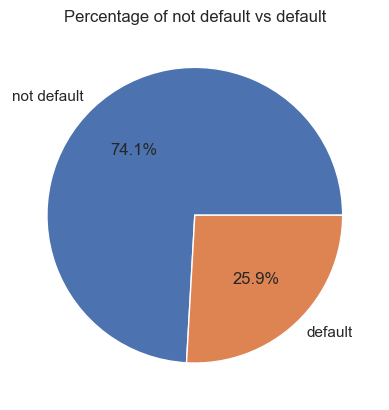

In [ ]:
sns.set()
plt.pie(dev_label_df.target.value_counts(), labels=['not default','default'], autopct= '%1.1f%%')
plt.title('Percentage of not default vs default')
plt.show()

## (2) Analyze Independent Variables

###     i. First, identify the 5 categories of features (Delequincy, spend, payment, balance, risk)

In [213]:
cat_vars = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'month', 'day_of_week' ]
features = dev_data_df.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
num_vars = list(filter(lambda x : x not in cat_vars, features))

delequincy_vars = filter(lambda x:x.startswith('D') and x not in cat_vars, features)
spend_vars = filter(lambda x:(x.startswith('S')) and (x not in cat_vars),features)
payment_vars = filter(lambda x:x.startswith('P') and x not in cat_vars, features)
balance_vars = filter(lambda x:x.startswith('B') and x not in cat_vars, features)
risk_vars = filter(lambda x:x.startswith('R') and x not in cat_vars, features)

### ii. Then, extract `Time` related variables.

In [ ]:
week_days ={1: 'Mon', 2: 'Tue', 3: 'Wen', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def extract_date_vars(df, date_var='S_2', sort_by=['customer_ID','S_2'], week_days=week_days):
    # change to datetime
    df[date_var] = pd.to_datetime(df[date_var])
    # sort by customer by date 
    df = df.sort_values(by=sort_by)
    # extract some date characteristics
    # month
    df['month'] = df[date_var].dt.month
    # day of week
    df['day_of_week'] = df[date_var].apply(lambda x : x.isocalendar()[-1])
    return df

In [ ]:
dev_data_df = extract_date_vars(dev_data_df, date_var='S_2', sort_by=['customer_ID','S_2'], week_days=week_days)

In [211]:
# save it, for future read in.
# dev_data_df.to_hdf('outputs/dev_data_df_extracted_time.h5', key='df')  
dev_data_df = pd.read_hdf('outputs/data_df_extracted_time.h5', 'df')  

In [ ]:
dev_data_df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,month,day_of_week
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,3,4
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,4,5
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,5,7
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,6,2
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21602,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775,11,7
21603,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858,12,6
21604,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,1,6
21605,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,2,2


In [ ]:
dev_data_df.shape

(5531451, 192)

In [ ]:
dev_data_df_cat = dev_data_df[cat_vars]
dev_data_df_cat

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68,month,day_of_week
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0,3,4
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0,4,5
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0,5,7
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0,6,2
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21602,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0,11,7
21603,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0,12,6
21604,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0,1,6
21605,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0,2,2


In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(drop='first')
# cat_transformed = ohe.fit_transform(dev_data_df_cat)
# one_hot_encoded_frame = pd.DataFrame.sparse.from_spmatrix(cat_transformed)
# one_hot_encoded_frame

In [328]:
dev_data_df[cat_vars].apply(lambda x: x.nunique(), axis=0)

B_30            3
B_38            7
D_114           2
D_116           2
D_117           7
D_120           2
D_126           3
D_63            6
D_64            4
D_66            2
D_68            7
month          12
day_of_week     7
dtype: int64

In [ ]:
# dev_data_df = dev_data_df.set_index(['customer_ID'])

In [ ]:
# # combine the dev data with target
# dev_data_df['target'] = dev_label_df

In [333]:
dev_data_df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,month,day_of_week
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,3,4
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,4,5
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,5,7
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,6,2
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21602,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775,11,7
21603,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858,12,6
21604,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,1,6
21605,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,2,2


In [ ]:
[dev_data_df.P_2.isna()].customer_ID[854]

'000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9d283d66c0fd2284f59'

In [ ]:
dev_data_df[dev_data_df.customer_ID == '000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9d283d66c0fd2284f59']

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,month,day_of_week
854,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2017-09-27,NaN,0.000401,0.038452,0.817871,0.008720,0.221313,0.009689,0.008148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,3
855,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2017-10-17,NaN,0.006691,0.113586,0.810547,0.008865,0.223877,0.008926,0.005302,...,NaN,1.002930,0.000124,0.922852,0.381592,1.005859,0.096619,0.545410,10,2
856,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2017-11-03,0.884277,0.009117,0.045654,0.419922,0.008865,0.256348,0.007641,0.044312,...,NaN,1.008789,0.008186,0.926270,0.377930,1.007812,0.098083,0.554688,11,5
857,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2017-12-18,0.882324,0.033936,0.021149,1.004883,0.002228,0.155518,0.000536,0.010483,...,NaN,1.002930,0.003345,0.928223,0.385010,1.006836,0.095276,0.546387,12,1
858,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2018-01-04,0.837891,0.537109,0.048370,1.001953,0.006199,0.163330,0.008705,0.012329,...,NaN,1.004883,0.003662,0.928223,0.385986,1.007812,0.093933,0.549805,1,4
859,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2018-02-25,0.859375,0.327881,0.059692,1.005859,0.003944,0.163696,0.004765,0.007595,...,NaN,1.005859,0.007725,0.931152,0.392334,1.002930,0.095764,0.549805,2,7
860,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,2018-03-26,0.858887,0.297607,0.041168,0.578613,0.002453,0.156616,0.000813,0.011360,...,NaN,1.003906,0.005112,0.925781,0.396729,1.006836,0.094971,0.546387,3,1


### III. Column-wised aggregation (Aggregated by `costomer_ID`)

* Aggregate `numerical` variables

In [ ]:
def generate_column_names_num(vars=num_vars, agg = ['mean', 'std', 'min', 'max', 'last']):
    tmp = []
    for a in agg:
        tmp_i = pd.Series(vars).apply(lambda x: x + '_' + a).tolist()
        tmp.append(tmp_i)
    column_names_num = list(itertools.chain(*zip(tmp[0],tmp[1],tmp[2],tmp[3],tmp[4] )))
    return column_names_num 

def column_agg_num(data, vars = num_vars, agg = ['mean', 'std', 'min', 'max', 'last']):
    num_vars_agg = data.groupby('customer_ID')[vars].agg(agg)
    column_names_num = generate_column_names_num(vars = vars, agg = agg)
    num_vars_agg.columns = column_names_num
    return num_vars_agg

In [ ]:
num_vars_agg = column_agg_num(data=dev_data_df, vars = num_vars, agg = ['mean', 'std', 'min', 'max', 'last'])

In [ ]:
num_vars_agg

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_144_mean,D_144_std,D_144_min,D_144_max,D_144_last,D_145_mean,D_145_std,D_145_min,D_145_max,D_145_last
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,0.005283,0.002598,0.000610,0.009613,0.002970,0.005814,0.003294,0.000996,0.009827,0.008530
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,0.004219,0.002871,0.000027,0.009567,0.003170,0.004902,0.002729,0.000796,0.009392,0.008514
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,0.005112,0.003638,0.000129,0.009415,0.000834,0.004498,0.002152,0.000443,0.006931,0.003445
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,0.004768,0.002654,0.000492,0.009918,0.005558,0.005234,0.003406,0.000029,0.009834,0.002983
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,0.004379,0.002634,0.000633,0.009438,0.006943,0.004219,0.003426,0.000083,0.009666,0.000905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,0.005604,0.003264,0.000439,0.009354,0.003010,0.005314,0.002673,0.000145,0.009865,0.004845
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,0.006050,0.002826,0.001254,0.009964,0.009232,0.005623,0.001671,0.002928,0.007778,0.006435
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,0.004860,0.002944,0.000340,0.009003,0.000340,0.003918,0.002744,0.000204,0.008537,0.002148


* Aggregate `categorical` variables

In [316]:
def generate_column_names_cat(vars=cat_vars, agg = ['count', 'nunique', 'mode']):
    tmp = []
    for a in agg:
        tmp_i = pd.Series(vars).apply(lambda x: x + '_' + str(a)).tolist()
        tmp.append(tmp_i)
    column_names_cat = list(itertools.chain(*zip(tmp[0],tmp[1],tmp[2])))
    return column_names_cat 

def column_agg_cat(data, vars = cat_vars, agg = ['count', 'nunique', pd.Series.mode]):
    cat_vars_agg = data.groupby('customer_ID')[vars].agg(agg)
    column_names_cat = ['_'.join(x) for x in cat_vars_agg.columns]
    cat_vars_agg.columns = column_names_cat
    
    mode_cols = filter(lambda x:x.endswith('_mode'), cat_vars_agg.columns)
    mode_cols = list(mode_cols)
    for col in mode_cols:
        cat_vars_agg[col] = cat_vars_agg[col].apply(lambda x: x.tolist()[0] if (isinstance( x, np.ndarray )) and (len(x)>0) else x)
    
    
    return cat_vars_agg

In [317]:
cat_vars_agg = column_agg_cat(data=dev_data_df, vars = cat_vars, agg = ['count', 'nunique', pd.Series.mode])

/var/folders/pg/gcb3fypn0mn3ycd6py5q__p80000gn/T/ipykernel_95590/3996945664.py:10: FutureWarning: ['D_66', 'day_of_week'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  cat_vars_agg = data.groupby('customer_ID')[vars].agg(agg)


In [318]:
cat_vars_agg

,B_30_count,B_30_nunique,B_30_mode,B_38_count,B_38_nunique,B_38_mode,D_114_count,D_114_nunique,D_114_mode,D_116_count,...,D_63_mode,D_64_count,D_64_nunique,D_64_mode,D_68_count,D_68_nunique,D_68_mode,month_count,month_nunique,month_mode
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,13,1,0.0,13,1,2.0,13,1,1.0,13,...,CR,13,1,O,13,1,6.0,13,12,3
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,13,1,0.0,13,1,2.0,13,1,1.0,13,...,CO,13,1,O,13,1,6.0,13,12,3
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,13,1,0.0,13,1,1.0,13,2,1.0,13,...,CO,13,1,R,13,1,6.0,13,12,3
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,13,1,0.0,13,1,2.0,13,1,1.0,13,...,CO,13,1,O,13,3,3.0,13,12,3
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,13,1,0.0,13,2,1.0,13,1,1.0,13,...,CO,13,1,O,13,1,6.0,13,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,13,1,0.0,13,1,2.0,13,1,0.0,13,...,CO,13,1,U,13,1,6.0,13,12,3
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,13,2,1.0,13,2,7.0,13,1,1.0,13,...,CO,13,1,R,13,1,6.0,13,12,3
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,13,1,0.0,13,2,3.0,13,1,1.0,13,...,CO,13,1,U,13,1,5.0,13,12,3


* Merge the `numerical` and `categorical` variables 

In [321]:
dev_agg_groupby = pd.concat([num_vars_agg, cat_vars_agg], axis=1)

In [322]:
dev_agg_groupby

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_mode,D_64_count,D_64_nunique,D_64_mode,D_68_count,D_68_nunique,D_68_mode,month_count,month_nunique,month_mode
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,CR,13,1,O,13,1,6.0,13,12,3
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,CO,13,1,O,13,1,6.0,13,12,3
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,CO,13,1,R,13,1,6.0,13,12,3
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,CO,13,1,O,13,3,3.0,13,12,3
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,CO,13,1,O,13,1,6.0,13,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,CO,13,1,U,13,1,6.0,13,12,3
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,CO,13,1,R,13,1,6.0,13,12,3
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,CO,13,1,U,13,1,5.0,13,12,3


In [326]:
cat_vars

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68',
 'month',
 'day_of_week']

In [327]:
cat_vars_agg.columns

Index(['B_30_count', 'B_30_nunique', 'B_30_mode', 'B_38_count', 'B_38_nunique',
       'B_38_mode', 'D_114_count', 'D_114_nunique', 'D_114_mode',
       'D_116_count', 'D_116_nunique', 'D_116_mode', 'D_117_count',
       'D_117_nunique', 'D_117_mode', 'D_120_count', 'D_120_nunique',
       'D_120_mode', 'D_126_count', 'D_126_nunique', 'D_126_mode',
       'D_63_count', 'D_63_nunique', 'D_63_mode', 'D_64_count', 'D_64_nunique',
       'D_64_mode', 'D_68_count', 'D_68_nunique', 'D_68_mode', 'month_count',
       'month_nunique', 'month_mode'],
      dtype='object')

In [323]:
dev_agg_groupby.loc['000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9d283d66c0fd2284f59']

P_2_mean         0.864746
P_2_std          0.019201
P_2_min          0.837891
P_2_max          0.884277
P_2_last         0.858887
                   ...   
D_68_nunique            2
D_68_mode             5.0
month_count             7
month_nunique           7
month_mode              1
Name: 000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9d283d66c0fd2284f59, Length: 918, dtype: object

In [324]:
# save to hdf, for future read in
# dev_agg_groupby.to_hdf('outputs/dev_agg_groupby.h5', key='df')
dev_agg_groupby = pd.read_hdf('outputs/dev_agg_groupby.h5', 'df')  

/var/folders/pg/gcb3fypn0mn3ycd6py5q__p80000gn/T/ipykernel_95590/2868152869.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['B_30_mode', 'B_38_mode', 'D_114_mode', 'D_116_mode', 'D_117_mode',
       'D_120_mode', 'D_63_mode', 'D_64_mode', 'D_68_mode'],
      dtype='object')]

  dev_agg_groupby.to_hdf('outputs/dev_agg_groupby.h5', key='df')


In [334]:
dev_agg_groupby.shape

(458913, 918)

* Get the `difference` within numerical variables

In [90]:
from tqdm.auto import tqdm
import itertools

# ====================================================
# Get the difference
# ====================================================
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1


In [91]:
# preprocess the dev dataset
# dev_data, test_data = get_dev_test_set()
dev_agg_diff = get_difference(dev_data_df, num_vars)

  0%|          | 0/458913 [00:00<?, ?it/s]

In [92]:
dev_agg_diff = dev_agg_diff.set_index('customer_ID')

In [93]:
dev_agg_diff

,P_2_diff1,D_39_diff1,B_1_diff1,B_2_diff1,R_1_diff1,S_3_diff1,D_41_diff1,B_3_diff1,D_42_diff1,D_43_diff1,...,D_136_diff1,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.002930,0.006691,-0.010452,-0.000977,0.005497,0.032043,-0.004570,-0.000278,NaN,NaN,...,NaN,NaN,NaN,0.005623,0.002258,0.002516,NaN,0.004711,-0.003378,0.004326
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.001465,-0.357910,0.000153,-0.001953,-0.000336,0.005981,-0.000725,-0.003666,NaN,-0.001404,...,NaN,NaN,NaN,-0.003675,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.014648,0.008179,-0.004032,-0.006348,-0.000305,NaN,-0.005718,0.002823,NaN,NaN,...,NaN,NaN,NaN,-0.000729,-0.002922,-0.002363,NaN,-0.002579,-0.006493,-0.002159
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.001953,-0.007294,-0.002022,-0.003906,0.004059,-0.027588,-0.003708,0.005138,NaN,-0.008057,...,NaN,NaN,NaN,-0.006611,-0.000744,0.000454,NaN,-0.001686,0.000740,-0.003864
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.007324,0.001427,-0.000843,0.002441,-0.004238,NaN,-0.004627,0.001568,NaN,0.007690,...,NaN,NaN,NaN,0.001035,0.001209,-0.001514,NaN,0.003178,0.000618,-0.001154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.031738,0.445068,0.012466,0.006836,-0.005211,-0.007812,0.003395,-0.004047,NaN,0.009399,...,NaN,NaN,NaN,-0.001801,-0.008423,0.003578,NaN,-0.006348,-0.002010,-0.000748
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,-0.007812,0.000702,-0.013672,0.002899,-0.000404,NaN,0.000031,0.001221,NaN,-0.385986,...,NaN,NaN,NaN,-0.003487,0.000931,-0.006737,NaN,0.003189,-0.000732,0.000248
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.013672,0.030396,0.004379,0.005859,-0.007427,-0.003601,0.006836,0.005638,NaN,-0.001831,...,NaN,NaN,NaN,-0.000126,-0.006363,-0.006874,NaN,-0.001686,-0.007454,-0.004471


In [335]:
# dev_agg_diff.to_hdf('outputs/dev_agg_difference.h5', key='df')
dev_agg_diff = pd.read_hdf('outputs/dev_agg_difference.h5', 'df')

* Merge the `groupby` aggregated dataframe, and the `difference` aggregated dataframe

In [336]:
dev_agg = pd.concat([dev_agg_groupby, dev_agg_diff], axis=1)

In [337]:
dev_agg

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_136_diff1,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,NaN,NaN,NaN,0.005623,0.002258,0.002516,NaN,0.004711,-0.003378,0.004326
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,NaN,NaN,NaN,-0.003675,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,NaN,NaN,NaN,-0.000729,-0.002922,-0.002363,NaN,-0.002579,-0.006493,-0.002159
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,NaN,NaN,NaN,-0.006611,-0.000744,0.000454,NaN,-0.001686,0.000740,-0.003864
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,NaN,NaN,NaN,0.001035,0.001209,-0.001514,NaN,0.003178,0.000618,-0.001154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,NaN,NaN,NaN,-0.001801,-0.008423,0.003578,NaN,-0.006348,-0.002010,-0.000748
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,NaN,NaN,NaN,-0.003487,0.000931,-0.006737,NaN,0.003189,-0.000732,0.000248
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,NaN,NaN,NaN,-0.000126,-0.006363,-0.006874,NaN,-0.001686,-0.007454,-0.004471


In [338]:
33+885+177

1095

In [415]:
dev_agg = pd.concat([dev_agg, dev_label_df], axis=1)

In [3]:
# dev_agg.to_hdf('outputs/dev_agg.h5', key='df')  
data = pd.read_hdf('outputs/dev_agg.h5', 'df')

In [4]:
dev_agg

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,NaN,NaN,0.005623,0.002258,0.002516,NaN,0.004711,-0.003378,0.004326,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,NaN,NaN,-0.003675,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,NaN,NaN,-0.000729,-0.002922,-0.002363,NaN,-0.002579,-0.006493,-0.002159,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,NaN,NaN,-0.006611,-0.000744,0.000454,NaN,-0.001686,0.000740,-0.003864,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,NaN,NaN,0.001035,0.001209,-0.001514,NaN,0.003178,0.000618,-0.001154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,NaN,NaN,-0.001801,-0.008423,0.003578,NaN,-0.006348,-0.002010,-0.000748,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,NaN,NaN,-0.003487,0.000931,-0.006737,NaN,0.003189,-0.000732,0.000248,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,NaN,NaN,-0.000126,-0.006363,-0.006874,NaN,-0.001686,-0.007454,-0.004471,0


# 3. Model training

## (1) Read in raw data

In [3]:
data = pd.read_hdf('outputs/dev_agg.h5', 'df')

In [4]:
cs = filter(lambda x: (x.endswith('_mode')) or  (x.endswith('_unique')) or (x.endswith('_count')), data.columns)
cs = list(cs)
len(cs)

22

* there are '[]' in the data, we remove them.

In [5]:
for c in cs:
    data[c] = data[c].apply(lambda x: str(x).strip('[]'))

In [6]:
data

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,NaN,NaN,0.005623,0.002258,0.002516,NaN,0.004711,-0.003378,0.004326,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,NaN,NaN,-0.003675,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,NaN,NaN,-0.000729,-0.002922,-0.002363,NaN,-0.002579,-0.006493,-0.002159,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,NaN,NaN,-0.006611,-0.000744,0.000454,NaN,-0.001686,0.000740,-0.003864,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,NaN,NaN,0.001035,0.001209,-0.001514,NaN,0.003178,0.000618,-0.001154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,NaN,NaN,-0.001801,-0.008423,0.003578,NaN,-0.006348,-0.002010,-0.000748,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,NaN,NaN,-0.003487,0.000931,-0.006737,NaN,0.003189,-0.000732,0.000248,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,NaN,NaN,-0.000126,-0.006363,-0.006874,NaN,-0.001686,-0.007454,-0.004471,0


In [7]:
# data.to_hdf('outputs/data_agg.h5', key='df')  
data = pd.read_hdf('outputs/data_agg.h5', 'df')

In [9]:
data.D_68_mode.value_counts()

6.0    230129
5.0    104132
3.0     43492
4.0     42607
2.0     19865
1.0     11672
         5251
0.0      1765
Name: D_68_mode, dtype: int64

In [ ]:
data

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,NaN,NaN,0.005623,0.002258,0.002516,NaN,0.004711,-0.003378,0.004326,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,NaN,NaN,-0.003675,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,NaN,NaN,-0.000729,-0.002922,-0.002363,NaN,-0.002579,-0.006493,-0.002159,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,NaN,NaN,-0.006611,-0.000744,0.000454,NaN,-0.001686,0.000740,-0.003864,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,NaN,NaN,0.001035,0.001209,-0.001514,NaN,0.003178,0.000618,-0.001154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,NaN,NaN,-0.001801,-0.008423,0.003578,NaN,-0.006348,-0.002010,-0.000748,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,NaN,NaN,-0.003487,0.000931,-0.006737,NaN,0.003189,-0.000732,0.000248,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,NaN,NaN,-0.000126,-0.006363,-0.006874,NaN,-0.001686,-0.007454,-0.004471,0


## (2) Missing columns drop

In [8]:
def missing(data):
    '''
    Function: find number and percent of missing values in the data
    Input: data
    Output: variables with missing value and the missing percent
    '''
    missing_number = data.isna().sum().sort_values(ascending=False)
    missing_percent = round((data.isna().sum()/data.isna().count()).sort_values(ascending=False),3)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    missing_df = missing_values[missing_values['Missing_Number']>0]
    return(missing_df)

In [9]:
missing_features = missing(data)
missing_features

,Missing_Number,Missing_Percent
D_87_diff1,458611,0.999
D_88_diff1,458452,0.999
D_87_std,458441,0.999
D_108_diff1,458408,0.999
D_87_last,458084,0.998
...,...,...
D_109_last,31,0.000
S_23_max,1,0.000
S_23_min,1,0.000
S_23_mean,1,0.000


In [10]:
features_to_drop = missing_features[missing_features.Missing_Percent > 0.5].index.tolist()
print(len(features_to_drop))

155


In [11]:
data = data.drop(features_to_drop, axis=1)

In [12]:
data

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_131_diff1,D_133_diff1,R_28_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_143_diff1,D_144_diff1,D_145_diff1,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,0.001400,0.006088,-0.005009,0.005623,0.002258,0.002516,0.004711,-0.003378,0.004326,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,0.000202,-0.006592,-0.004353,-0.003675,0.002853,0.003052,-0.004986,0.000641,0.004929,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,0.002958,0.007904,0.002590,-0.000729,-0.002922,-0.002363,-0.002579,-0.006493,-0.002159,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,-0.003822,0.000631,0.004574,-0.006611,-0.000744,0.000454,-0.001686,0.000740,-0.003864,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,0.002892,0.002411,0.001291,0.001035,0.001209,-0.001514,0.003178,0.000618,-0.001154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,0.001736,-0.003624,-0.000893,-0.001801,-0.008423,0.003578,-0.006348,-0.002010,-0.000748,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,-0.000977,0.000000,0.001362,-0.003487,0.000931,-0.006737,0.003189,-0.000732,0.000248,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,-0.000160,0.002329,0.003067,-0.000126,-0.006363,-0.006874,-0.001686,-0.007454,-0.004471,0


## (3) categorical distribution analysis

In [13]:
cat_cols = filter(lambda x: x.endswith('_mode') , data.columns)
cat_cols = list(cat_cols)
len(cat_cols)

11

In [14]:
data_cat = data[cat_cols + ['target']]
data_cat = data_cat.reset_index()
data_cat

,customer_ID,B_30_mode,B_38_mode,D_114_mode,D_116_mode,D_117_mode,D_120_mode,D_126_mode,D_63_mode,D_64_mode,D_68_mode,month_mode,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0,3,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0,3,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.0,1.0,1.0,0.0,-1.0,0.0,1.0,CO,R,6.0,3,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.0,2.0,1.0,0.0,6.0,0.0,1.0,CO,O,3.0,3,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,6.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0.0,2.0,0.0,0.0,4.0,1.0,1.0,CO,U,6.0,3,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,1.0,7.0,1.0,0.0,3.0,0.0,1.0,CO,R,6.0,3,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0.0,3.0,1.0,0.0,-1.0,0.0,1.0,CO,U,5.0,3,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,0.0,3.0,1.0,0.0,2.0,0.0,1.0,CO,U,4.0,3,1


In [17]:
data_cat.dtypes

customer_ID    object
B_30_mode      object
B_38_mode      object
D_114_mode     object
D_116_mode     object
D_117_mode     object
D_120_mode     object
D_126_mode     object
D_63_mode      object
D_64_mode      object
D_68_mode      object
month_mode     object
target          int64
dtype: object

/var/folders/pg/gcb3fypn0mn3ycd6py5q__p80000gn/T/ipykernel_9530/365515149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tmp['cnt'] = 1
/Users/yifeiguo/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/var/folders/pg/gcb3fypn0mn3ycd6py5q__p80000gn/T/ipykernel_9530/365515149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

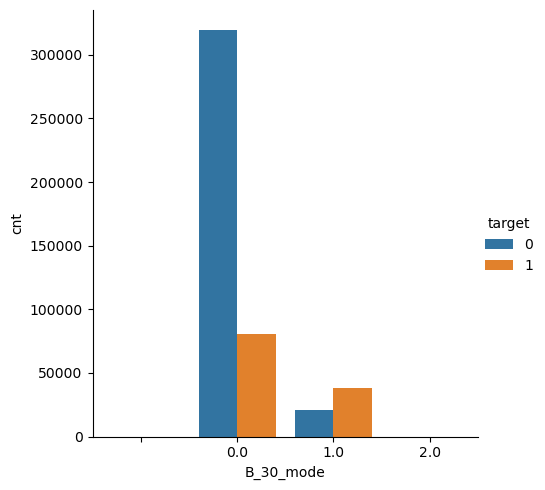

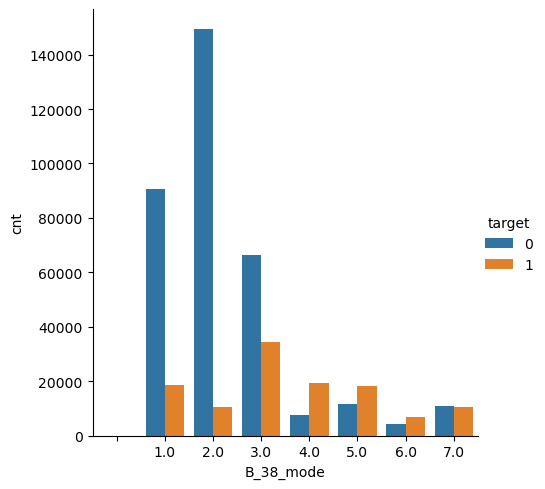

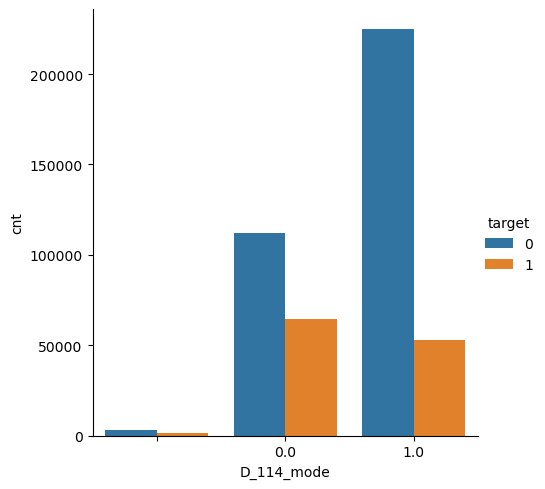

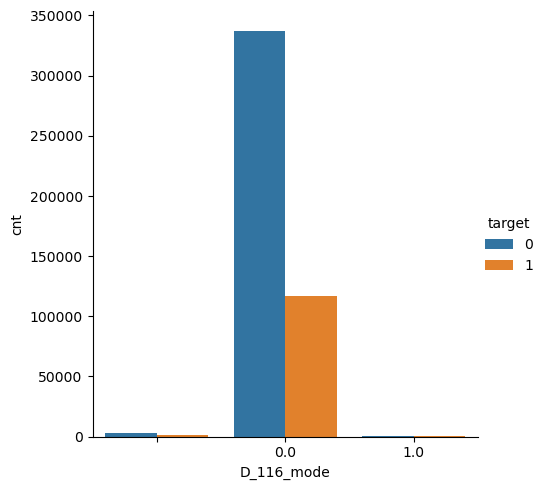

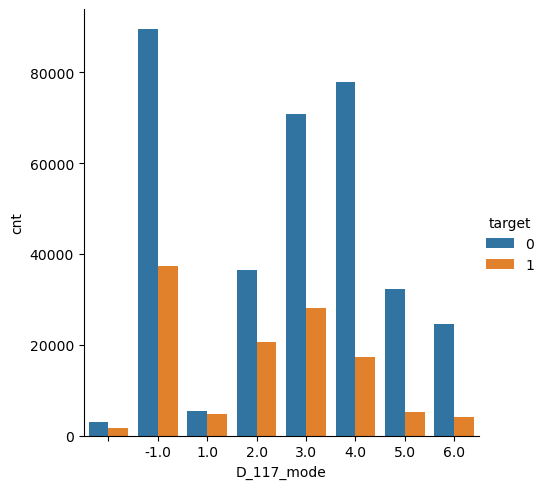

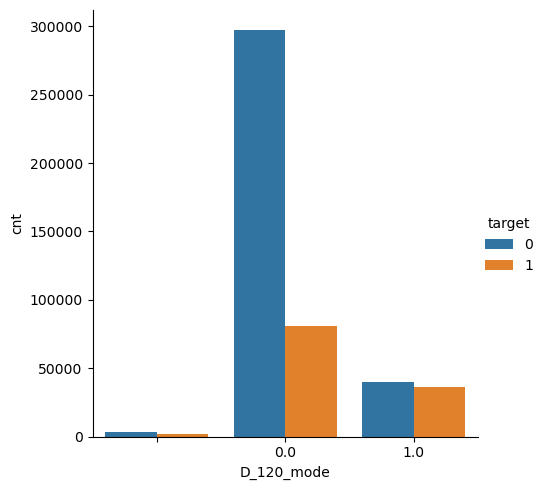

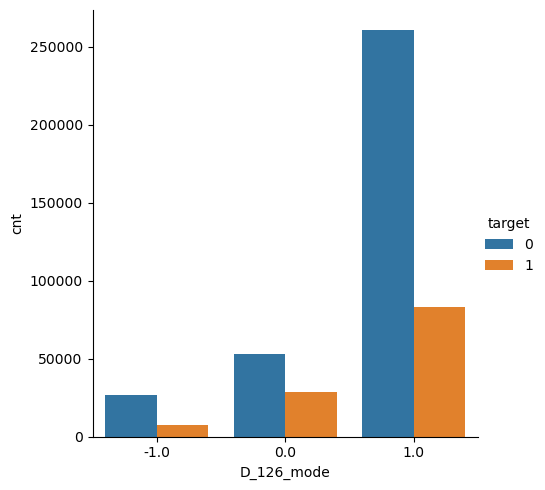

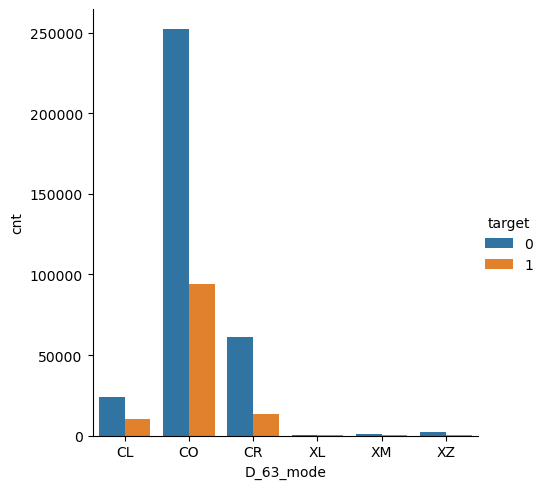

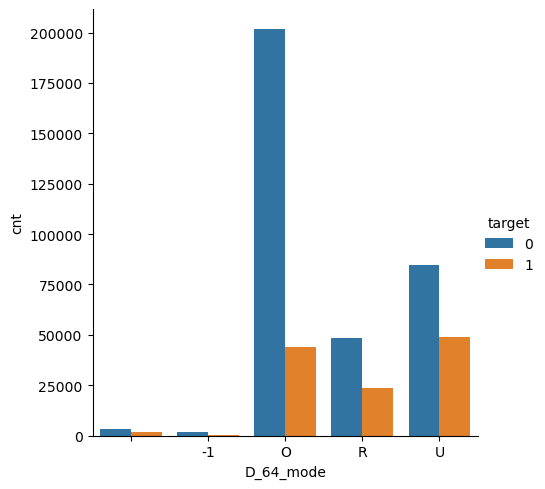

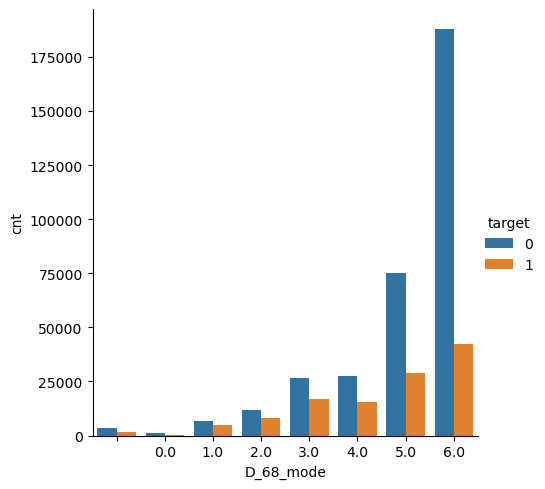

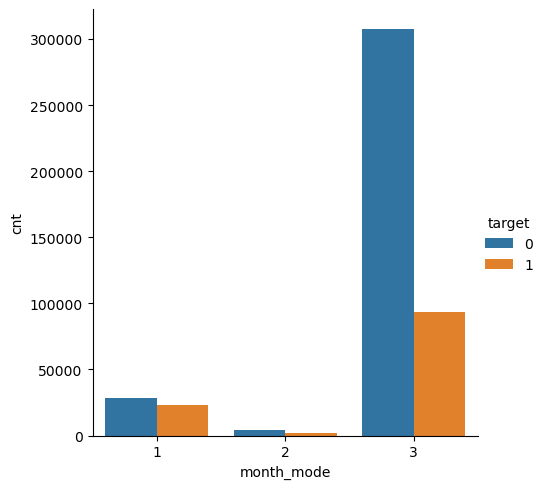

In [15]:
for c in cat_cols:
    data_tmp = data[[c, 'target']]
    data_tmp['cnt'] = 1
    data_tmp = data_tmp.groupby([c,'target'], as_index=False).count()
    sns.factorplot(x = c, y='cnt', 
                   hue = 'target',data=data_tmp, kind='bar')

## (4) train test split

In [16]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['target'])
y = np.array(data['target'])

# split
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)


In [17]:
print('dev', X_dev.shape)
print('test', X_test.shape)
# print('train', X_train.shape)
# print('val', X_val.shape)

dev (367130, 940)
test (91783, 940)


## (5) encoding and standardization

In [18]:
# get categorical features
cat_cols = filter(lambda x: x.endswith('_mode'), X_dev.columns)
cat_cols = list(cat_cols)
len(cat_cols)

11

In [19]:
# get numerical features
num_cols = list(set(X_dev.columns) - set(cat_cols))
len(num_cols)

929

In [30]:
# Create pipelines for numerical and categorical features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

te = TargetEncoder()

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('target-encode',te)
])

# Create ColumnTransformer to apply pipeline for each column type
from sklearn.compose import ColumnTransformer
col_trans = ColumnTransformer(transformers=[
            ('num_pipeline',num_pipeline,num_cols),
            ('cat_pipeline',cat_pipeline,cat_cols)
            ],
            remainder='drop',
            n_jobs=-1)
    
# # Add a model to a final pipeline, clf_pipeline
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0)
# clf_pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', clf)
# ])

/Users/yifeiguo/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/yifeiguo/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [31]:
col_trans

ColumnTransformer(n_jobs=-1,
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', MinMaxScaler())]),
                                 ['D_121_mean', 'B_26_last', 'D_44_mean',
                                  'R_19_max', 'D_94_last', 'B_32_diff1',
                                  'D_107_last', 'S_26_min', 'B_41_max',
                                  'R_13_std', 'D_133_min', 'D_114_count',
                                  'D_130_diff1', 'D_96_last', 'D_39_diff1',
                                  'B_17_last', 'S_25_mean', 'S_27_last',
                                  '...
                                  'D_141_min', 'B_6_max', 'D_65_std',
                                  'D_80_last', 'R_24_min', 'D_62_std',
                                  'D_52_last', 'B_36_std', 'B_17_mean', ...]),
                                ('cat_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('target-encode',
                                                  TargetEncoder())]),
                                 ['B_30_mode', 'B_38_mode', 'D_114_mode',
                                  'D_116_mode', 'D_117_mode', 'D_120_mode',
                                  'D_126_mode', 'D_63_mode', 'D_64_mode',
                                  'D_68_mode', 'month_mode'])])

In [34]:
X_dev_new = col_trans.fit_transform(X_dev, y_dev)
X_test_new = col_trans.transform(X_test)

/Users/yifeiguo/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/yifeiguo/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [35]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [36]:
columns_names = get_column_names_from_ColumnTransformer(col_trans)
columns_names[-11:] = cat_cols
columns_names

['D_121_mean',
 'B_26_last',
 'D_44_mean',
 'R_19_max',
 'D_94_last',
 'B_32_diff1',
 'D_107_last',
 'S_26_min',
 'B_41_max',
 'R_13_std',
 'D_133_min',
 'D_114_count',
 'D_130_diff1',
 'D_96_last',
 'D_39_diff1',
 'B_17_last',
 'S_25_mean',
 'S_27_last',
 'D_77_std',
 'D_70_std',
 'R_18_mean',
 'D_141_min',
 'B_6_max',
 'D_65_std',
 'D_80_last',
 'R_24_min',
 'D_62_std',
 'D_52_last',
 'B_36_std',
 'B_17_mean',
 'B_13_mean',
 'R_23_last',
 'B_30_count',
 'D_84_min',
 'S_23_min',
 'R_7_mean',
 'D_119_diff1',
 'B_23_std',
 'S_27_mean',
 'B_40_last',
 'D_41_std',
 'S_15_std',
 'B_6_last',
 'B_41_last',
 'D_56_std',
 'D_41_min',
 'D_130_max',
 'D_48_diff1',
 'S_23_max',
 'R_6_max',
 'S_18_diff1',
 'B_12_std',
 'B_20_diff1',
 'D_112_diff1',
 'D_117_nunique',
 'D_47_mean',
 'D_124_last',
 'B_24_max',
 'D_116_count',
 'B_14_diff1',
 'D_92_diff1',
 'D_128_diff1',
 'B_10_mean',
 'S_8_max',
 'R_27_min',
 'D_123_mean',
 'D_48_max',
 'B_16_mean',
 'D_75_max',
 'R_11_min',
 'D_59_diff1',
 'S_3_dif

In [37]:
len(columns_names)

940

In [38]:
X_dev_new = pd.DataFrame(X_dev_new, columns=columns_names)
X_test_new = pd.DataFrame(X_test_new, columns=columns_names)


In [39]:
X_dev_new

,D_121_mean,B_26_last,D_44_mean,R_19_max,D_94_last,B_32_diff1,D_107_last,S_26_min,B_41_max,R_13_std,...,B_38_mode,D_114_mode,D_116_mode,D_117_mode,D_120_mode,D_126_mode,D_63_mode,D_64_mode,D_68_mode,month_mode
0,0.400101,2.407060e-06,0.202718,0.008777,0.000748,0.502008,0.050278,3.480590e-06,0.000491,0.327269,...,0.340508,0.363743,0.257143,0.294010,0.213448,0.241829,0.271802,0.364559,0.277113,0.233134
1,0.218923,3.355807e-06,0.001161,0.009623,0.006823,0.499628,0.000450,6.057989e-08,0.000437,0.011947,...,0.066330,0.363743,0.257143,0.179993,0.213448,0.349130,0.299432,0.178450,0.183968,0.233134
2,0.498071,1.323179e-05,0.001019,0.009669,0.001810,0.500663,0.001071,3.733924e-06,0.000496,0.008776,...,0.169819,0.189817,0.257143,0.294010,0.213448,0.241829,0.271802,0.364559,0.277113,0.233134
3,0.440899,8.761135e-06,0.042974,0.009578,0.003814,0.500365,0.000766,1.440700e-05,0.000426,0.012612,...,0.720798,0.189817,0.257143,0.179993,0.213448,0.241829,0.271802,0.178450,0.277113,0.448115
4,0.437141,1.215406e-02,0.044170,0.009215,0.003978,0.499666,0.050095,5.715804e-05,0.000439,0.008481,...,0.340508,0.363743,0.257143,0.179993,0.213448,0.241829,0.178308,0.364559,0.385695,0.233134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367125,0.293005,3.817513e-06,0.018077,0.008188,0.002875,0.498672,0.051047,7.789942e-03,0.000488,0.009469,...,0.340508,0.189817,0.257143,0.179993,0.213448,0.241829,0.299432,0.178450,0.183968,0.233134
367126,0.269519,5.827619e-07,0.000802,0.009042,0.005542,0.499046,0.000613,7.324659e-06,0.050439,0.011482,...,0.340508,0.189817,0.257143,0.179993,0.213448,0.241829,0.271802,0.178450,0.183968,0.233134
367127,0.261198,5.593951e-06,0.001010,0.009110,0.002892,0.499968,0.050461,2.126538e-05,0.000487,0.009675,...,0.066330,0.189817,0.257143,0.294010,0.213448,0.241829,0.271802,0.178450,0.277113,0.233134
367128,0.349102,9.836570e-06,0.099157,0.008860,0.007280,0.504118,0.051047,2.712510e-05,0.000414,0.009615,...,0.340508,0.363743,0.257143,0.361334,0.213448,0.241829,0.271802,0.328943,0.183968,0.233134


In [42]:
# X_dev_new.to_hdf('outputs/X_dev_new.h5', key='df')  
X_dev_new = pd.read_hdf('outputs/X_dev_new.h5', 'df')

In [44]:
# X_test_new.to_hdf('outputs/X_test_new.h5', key='df')  
X_test_new = pd.read_hdf('outputs/X_test_new.h5', 'df')

## (6) feature selection

https://www.dataknowsall.com/featureselection.html

https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif   # we use F-TEST for numerical variables
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns


In [82]:
def select_features(X_train, y_train, X_test, k_value='all'):
    fs = SelectKBest(score_func=f_classif, k=k_value)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [83]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_dev_new, y_dev, X_test_new)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 10974.086792
Feature 1: 709.608975
Feature 2: 110276.956139
Feature 3: 5447.564664
Feature 4: 1950.184179
Feature 5: 216.285340
Feature 6: 5646.756700
Feature 7: 222.763133
Feature 8: 6021.971650
Feature 9: 22203.132931
Feature 10: 3670.650848
Feature 11: 6278.841922
Feature 12: 429.314221
Feature 13: 1642.890102
Feature 14: 6869.738915
Feature 15: 46245.180504
Feature 16: 52107.467810
Feature 17: 1211.906058
Feature 18: 4820.273181
Feature 19: 53053.229994
Feature 20: 15.593797
Feature 21: 5517.234508
Feature 22: 285.026381
Feature 23: 3928.719223
Feature 24: 1462.242148
Feature 25: 427.120755
Feature 26: 14902.758377
Feature 27: 20410.783406
Feature 28: 733.075977
Feature 29: 47131.502831
Feature 30: 383.222736
Feature 31: 20.751369
Feature 32: 3930.744071
Feature 33: 1708.267105
Feature 34: 194.073114
Feature 35: 5912.335396
Feature 36: 43.091750
Feature 37: 46323.885415
Feature 38: 22.652185
Feature 39: 605.377343
Feature 40: 63985.404742
Feature 41: 36239.406559
Feature

In [84]:
X_train_fs, X_test_fs, fs = select_features(X_dev_new, y_dev, X_test_new, 300)

In [85]:
features_selected = fs.get_feature_names_out()

In [86]:
X_dev_selected = X_dev_new[features_selected]
X_dev_selected

,D_44_mean,R_13_std,B_17_last,S_25_mean,D_70_std,D_62_std,D_52_last,B_17_mean,B_23_std,D_41_std,...,B_28_min,B_20_min,B_16_max,D_41_max,B_25_last,D_43_std,B_30_mode,B_38_mode,D_120_mode,D_64_mode
0,0.202718,0.327269,0.882495,0.657930,0.162753,0.001990,0.018026,0.930367,0.129216,0.000766,...,0.033973,0.062742,1.000000,0.001256,0.171858,0.017881,0.645773,0.340508,0.213448,0.364559
1,0.001161,0.011947,0.627598,0.678046,0.001327,0.014177,0.115527,0.674114,0.011815,0.000841,...,0.000443,0.000157,0.090605,0.001310,0.170180,0.005717,0.201569,0.066330,0.213448,0.178450
2,0.001019,0.008776,0.627598,0.677950,0.001305,0.034821,0.335505,0.674114,0.007602,0.000710,...,0.000789,0.001035,0.091633,0.001291,0.169608,0.010131,0.201569,0.169819,0.213448,0.364559
3,0.042974,0.012612,0.627598,0.678240,0.102719,0.003775,0.181088,0.674114,0.041497,0.000748,...,0.047233,0.005497,0.501933,0.001297,0.198068,0.023635,0.201569,0.720798,0.213448,0.178450
4,0.044170,0.008481,0.981625,0.669052,0.073739,0.000740,0.153231,0.990329,0.083248,0.076080,...,0.074619,0.474130,0.999033,0.139625,0.204243,0.025287,0.201569,0.340508,0.213448,0.364559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367125,0.018077,0.009469,0.994197,0.656286,0.060134,0.062647,0.370567,0.829786,0.015593,0.000772,...,0.056135,0.295938,0.999033,0.001195,0.206046,0.018108,0.201569,0.340508,0.213448,0.178450
367126,0.000802,0.011482,0.902805,0.677950,0.001422,0.011857,0.100218,0.894100,0.059830,0.000766,...,0.003364,0.991296,1.000000,0.001300,0.178430,0.000774,0.201569,0.340508,0.213448,0.178450
367127,0.001010,0.009675,0.627598,0.677950,0.001284,0.000631,0.089231,0.674114,0.012412,0.000766,...,0.001691,0.000577,0.090001,0.001302,0.178070,0.010756,0.201569,0.066330,0.213448,0.178450
367128,0.099157,0.009615,0.885396,0.614700,0.001187,0.001416,0.061283,0.656187,0.102465,0.000570,...,0.024514,0.000068,0.834139,0.001251,0.174804,0.017159,0.201569,0.340508,0.213448,0.328943


In [87]:
X_test_selected = X_test_new[features_selected]
X_test_selected

,D_44_mean,R_13_std,B_17_last,S_25_mean,D_70_std,D_62_std,D_52_last,B_17_mean,B_23_std,D_41_std,...,B_28_min,B_20_min,B_16_max,D_41_max,B_25_last,D_43_std,B_30_mode,B_38_mode,D_120_mode,D_64_mode
0,0.000915,0.009721,0.998066,0.658801,0.001520,0.011857,0.148308,0.947292,0.067192,0.112265,...,0.061390,0.992263,1.000000,0.198907,0.268370,0.001916,0.201569,0.340508,0.213448,0.178450
1,0.080206,0.010854,0.995164,0.678143,0.031283,0.006596,0.246289,0.444628,0.190871,0.000739,...,0.094154,0.000492,0.255318,0.001291,0.171602,0.011805,0.201569,0.066330,0.213448,0.178450
2,0.049817,0.009354,0.969536,0.627176,0.000880,0.000794,0.003976,0.606863,0.063336,0.124476,...,0.003613,0.297631,0.999033,0.160686,0.174880,0.015802,0.645773,0.720798,0.213448,0.364559
3,0.004776,0.011808,0.627598,0.677950,0.076388,0.030115,0.213749,0.674114,0.093149,0.000627,...,0.021980,0.000364,0.009291,0.001191,0.169668,0.022771,0.201569,0.169819,0.213448,0.178450
4,0.000846,0.008399,0.627598,0.678046,0.001436,0.000536,0.205704,0.674114,0.014420,0.000884,...,0.000597,0.000846,0.084742,0.001324,0.170512,0.038140,0.201569,0.066330,0.213448,0.178450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91778,0.001155,0.012204,0.995164,0.677853,0.043417,0.026474,0.131497,0.579300,0.023757,0.053689,...,0.001414,0.061714,0.999033,0.080733,0.174700,0.023635,0.201569,0.340508,0.213448,0.178450
91779,0.023173,0.010527,0.798356,0.653385,0.055477,0.005202,0.029929,0.838490,0.118712,0.010067,...,0.032211,0.991296,1.000000,0.011838,0.169465,0.008800,0.201569,0.340508,0.213448,0.178450
91780,0.000877,0.010978,0.627598,0.678046,0.001317,0.011857,0.413073,0.674114,0.010988,0.000838,...,0.000056,0.000396,0.088429,0.001170,0.169681,0.000547,0.201569,0.169819,0.213448,0.178450
91781,0.055704,0.010421,0.695841,0.677950,0.050950,0.000723,0.267062,0.938104,0.113140,0.000915,...,0.067139,0.291586,0.999033,0.001300,0.200697,0.010737,0.201569,0.612993,0.213448,0.178450


In [88]:
X_dev_selected.to_hdf('outputs/X_dev_selected.h5', key='df')  
# X_dev_selected = pd.read_hdf('outputs/X_dev_selected.h5', 'df')

In [89]:
X_test_selected.to_hdf('outputs/X_test_selected.h5', key='df')  
# X_test_selected = pd.read_hdf('outputs/X_test_selected.h5', 'df')

## (7) Model training

In [116]:
## ESSENTIALS
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import sys
import pickle
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
import random
random.seed(75)
from tqdm.notebook import tqdm_notebook 
from functools import partial, reduce

### warnings setting
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import catboost
from catboost import Pool, CatBoostClassifier 
import lightgbm as lgb
import joblib
import pickle
from tqdm.notebook import tqdm_notebook 
import uuid

##### LOGGING Stettings #####
import logging
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# Create formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',)
handler.setFormatter(formatter)
# Set STDERR handler as the only handler 
logger.handlers = [handler]

#### plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

sns.set(rc={'axes.facecolor':'#f9ecec', 'figure.facecolor':'#f9ecec'})

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

### Plotly settings
theme_palette={
    'base': '#a3d3eb',
    'complementary':'#ebbba3',
    'triadic' : '#eba3d3', 
    'backgound' : '#f6fbfd' 
}

temp=dict(layout=go.Layout(font=dict(family="Ubuntu", size=14), 
                           height=600, 
                         legend=dict(#traceorder='reversed',
                            orientation="v",
                            y=1.15,
                            x=0.9),
                    plot_bgcolor = theme_palette['backgound'],
                      paper_bgcolor = theme_palette['backgound']))


SAVED=True

In [110]:
X_dev_selected.head()

,D_44_mean,R_13_std,B_17_last,S_25_mean,D_70_std,D_62_std,D_52_last,B_17_mean,B_23_std,D_41_std,...,B_28_min,B_20_min,B_16_max,D_41_max,B_25_last,D_43_std,B_30_mode,B_38_mode,D_120_mode,D_64_mode
0,0.202718,0.327269,0.882495,0.657930,0.162753,0.001990,0.018026,0.930367,0.129216,0.000766,...,0.033973,0.062742,1.000000,0.001256,0.171858,0.017881,0.645773,0.340508,0.213448,0.364559
1,0.001161,0.011947,0.627598,0.678046,0.001327,0.014177,0.115527,0.674114,0.011815,0.000841,...,0.000443,0.000157,0.090605,0.001310,0.170180,0.005717,0.201569,0.066330,0.213448,0.178450
2,0.001019,0.008776,0.627598,0.677950,0.001305,0.034821,0.335505,0.674114,0.007602,0.000710,...,0.000789,0.001035,0.091633,0.001291,0.169608,0.010131,0.201569,0.169819,0.213448,0.364559
3,0.042974,0.012612,0.627598,0.678240,0.102719,0.003775,0.181088,0.674114,0.041497,0.000748,...,0.047233,0.005497,0.501933,0.001297,0.198068,0.023635,0.201569,0.720798,0.213448,0.178450
4,0.044170,0.008481,0.981625,0.669052,0.073739,0.000740,0.153231,0.990329,0.083248,0.076080,...,0.074619,0.474130,0.999033,0.139625,0.204243,0.025287,0.201569,0.340508,0.213448,0.364559


In [123]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [125]:
from optuna.integration import LightGBMPruningCallback


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_dev_selected, y_dev)
study.optimize(func, n_trials=20)

In [129]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.22743
	Best params:
		n_estimators: 10000
		learning_rate: 0.15692825977529412
		num_leaves: 580
		max_depth: 7
		min_data_in_leaf: 6600
		lambda_l1: 15
		lambda_l2: 40
		min_gain_to_split: 7.443386256339056
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.4


## (8) Refit the model with the best parameters

In [138]:
model = lgb.LGBMClassifier(objective="binary", **study.best_params)
model.fit(
    X_dev_selected,
    y_dev,
    eval_metric="binary_logloss"
)
preds = model.predict_proba(X_dev_selected)
log_loss(y_dev, preds)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.443386256339056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.443386256339056
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15


0.21951979584787112

## (9) Evaluation metrics

In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

In [190]:
pred_class_dev = model.predict(X_dev_selected)
cm_dev = confusion_matrix(y_dev, pred_class_dev)
cm_dev

array([[253670,  18552],
       [ 19622,  75286]])

* dev set

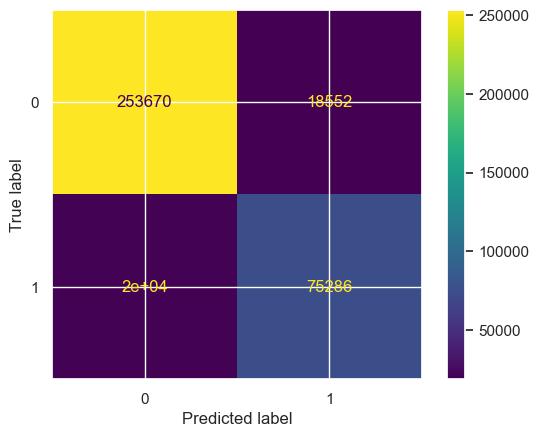

In [259]:
sns.set()
ConfusionMatrixDisplay(cm_dev).plot()

In [240]:
print("***** Development Set Analysis *****")
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

test_acc = sum(np.where(pred_class_dev == y_dev, 1, 0))/y_dev.shape[0]
print("Accuracy on Test Set : {:0.4f}".format(test_acc))
prfs = precision_recall_fscore_support(y_dev, pred_class_dev, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

***** Development Set Analysis *****
Accuracy on Test Set : 0.8960
Precision :  0.865249457218983
Recall :  0.8625510765742427
F1 Score :  0.86388565860867


In [263]:
from sklearn.metrics import average_precision_score
average_precision_score(y_dev, pred_class_dev_prob[:,1])

0.8840464531195861

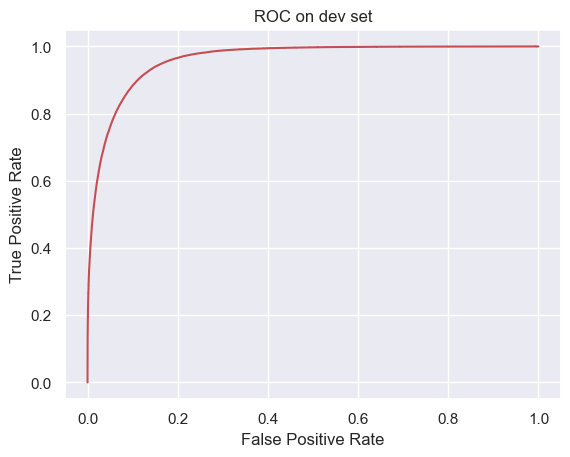

In [161]:
pred_prob_dev = model.predict_proba(X_dev_selected)[:,1]

fpr, tpr, _ = roc_curve(y_dev, pred_prob_dev)
plt.plot(fpr,tpr, 'r')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC on dev set')
plt.show()

* test set

In [256]:
pred_class_test = model.predict(X_test_selected)
cm_test = confusion_matrix(y_test, pred_class_test)
cm_test

array([[63334,  4529],
       [ 4769, 19151]])

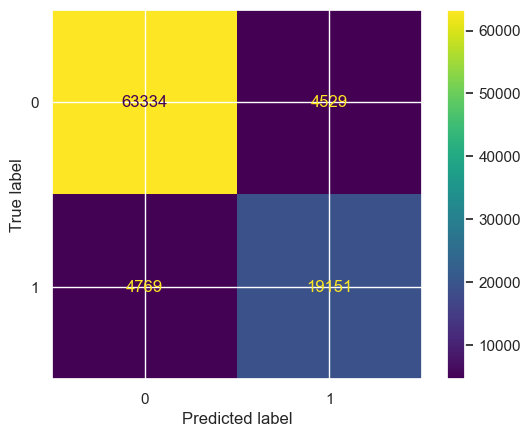

In [257]:
ConfusionMatrixDisplay(cm_test).plot()

In [196]:
print("***** Test Set Analysis *****")
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

test_acc = sum(np.where(pred_class_test == y_test, 1, 0))/y_test.shape[0]
print("Accuracy on Test Set : {:0.4f}".format(test_acc))
prfs = precision_recall_fscore_support(y_test, pred_class_test, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

***** Test Set Analysis *****
Accuracy on Test Set : 0.8987
Precision :  0.8693576351683717
Recall :  0.8669448464487054
F1 Score :  0.8681395611507918


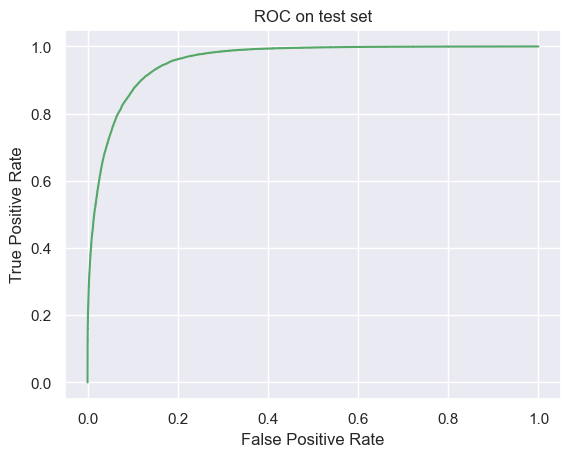

In [162]:
pred_prob_test = model.predict_proba(X_test_selected)[:,1]

fpr, tpr, _ = roc_curve(y_test, pred_prob_test)
plt.plot(fpr,tpr, 'g')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC on test set')
plt.show()

In [242]:
pred_class_test = model.predict(X_test_selected)
pred_class_test

pred_class_test_prob = model.predict_proba(X_test_selected)
pred_class_test_prob

array([[0.3063689 , 0.6936311 ],
       [0.88522792, 0.11477208],
       [0.06092121, 0.93907879],
       ...,
       [0.99846008, 0.00153992],
       [0.77642825, 0.22357175],
       [0.07626509, 0.92373491]])

In [246]:
lightgbm_test_prediction = pd.DataFrame({'y_test': y_test,
                                        'y_pred_class' : pred_class_test,
                                        'y_pred_prob' : pred_class_test_prob[:,1]}) 
lightgbm_test_prediction                                     

,y_test,y_pred_class,y_pred_prob
0,1,1,0.693631
1,0,0,0.114772
2,1,1,0.939079
3,0,0,0.004745
4,0,0,0.001182
...,...,...,...
91778,0,0,0.087635
91779,0,1,0.672888
91780,0,0,0.001540
91781,0,0,0.223572


In [253]:
lightgbm_test_prediction.to_csv('lightgbm_test_prediction.csv')

In [248]:
pred_class_dev = model.predict(X_dev_selected)
pred_class_dev

pred_class_dev_prob = model.predict_proba(X_dev_selected)
pred_class_dev_prob

array([[0.05605853, 0.94394147],
       [0.99478142, 0.00521858],
       [0.99783122, 0.00216878],
       ...,
       [0.99739215, 0.00260785],
       [0.44853899, 0.55146101],
       [0.99867465, 0.00132535]])

In [249]:
lightgbm_dev_prediction = pd.DataFrame({'y_dev': y_dev,
                                        'y_pred_class' : pred_class_dev,
                                        'y_pred_prob' : pred_class_dev_prob[:,1]}) 
lightgbm_dev_prediction                                     

,y_dev,y_pred_class,y_pred_prob
0,1,1,0.943941
1,0,0,0.005219
2,0,0,0.002169
3,0,0,0.277665
4,1,1,0.975246
...,...,...,...
367125,0,0,0.009285
367126,0,0,0.048600
367127,0,0,0.002608
367128,0,1,0.551461


In [254]:
lightgbm_dev_prediction.to_csv('lightgbm_dev_prediction.csv')

## (10) Model calibration

In [164]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

def brier_score(y_test, y_pred):
    losses = np.subtract(y_test, y_pred)**2
    brier_score = losses.sum()/len(losses)
    return(brier_score)
    

brier_score(y_test, pred_prob_test)

0.07201522121455298

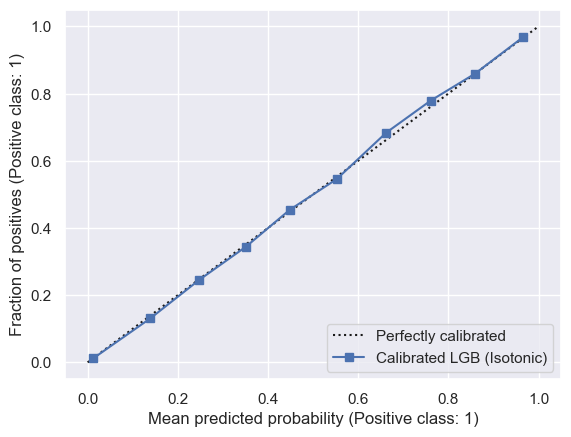

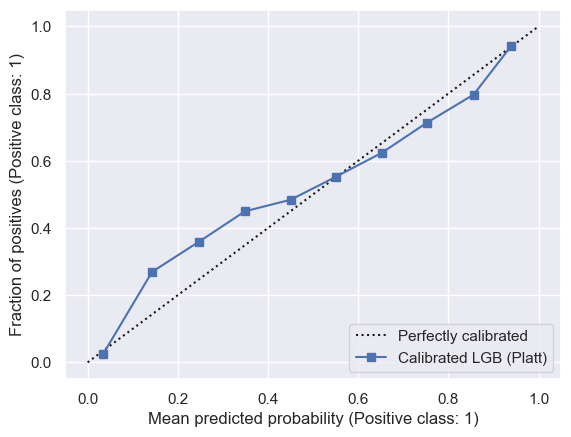

In [169]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

# Isotonic Regression
cal_LGB_isotonic = CalibratedClassifierCV(model, cv = "prefit", method = "isotonic")
cal_LGB_isotonic.fit(X_dev_selected, y_dev)
display_isotonic = CalibrationDisplay.from_estimator(cal_LGB_isotonic, X_test_selected, y_test, n_bins = 10, name = 'Calibrated LGB (Isotonic)')

# Platt Scaling
cal_LGB_platt = CalibratedClassifierCV(model, cv = "prefit", method = "sigmoid")
cal_LGB_platt.fit(X_dev_selected, y_dev)
display_platt = CalibrationDisplay.from_estimator(cal_LGB_platt, X_test_selected, y_test, n_bins = 10, name = 'Calibrated LGB (Platt)')

In [170]:
print("Brier Score for Isotonic Regression : {:0.4f}".format(brier_score_loss(y_test, cal_LGB_isotonic.predict_proba(X_test_selected)[:, 1])))
print("Brier Score for Platt Scaling       : {:0.4f}".format(brier_score_loss(y_test, cal_LGB_platt.predict_proba(X_test_selected)[:, 1])))

Brier Score for Isotonic Regression : 0.0711
Brier Score for Platt Scaling       : 0.0732


* We find Isotonic Regression is better, then use Isotonic Regression to predict the final test set target

In [197]:
pred_class_test = cal_LGB_isotonic.predict(X_test_selected)
cm_test = confusion_matrix(y_test, pred_class_test)
cm_test

array([[63395,  4468],
       [ 4835, 19085]])

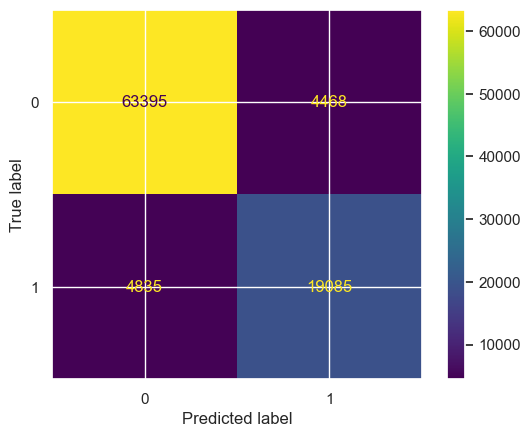

In [199]:
ConfusionMatrixDisplay(cm_test).plot()

In [200]:
print("***** Calibrated Test Set Analysis *****")
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

pred_class_test = cal_LGB_isotonic.predict(X_test_selected)
test_acc = sum(np.where(pred_class_test == y_test, 1, 0))/y_test.shape[0]
print("Accuracy on Test Set : {:0.4f}".format(test_acc))
prfs = precision_recall_fscore_support(y_test, pred_class_test, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

***** Calibrated Test Set Analysis *****
Accuracy on Test Set : 0.8986
Precision :  0.8697184587217546
Recall :  0.8660146826773811
F1 Score :  0.8678391555810578


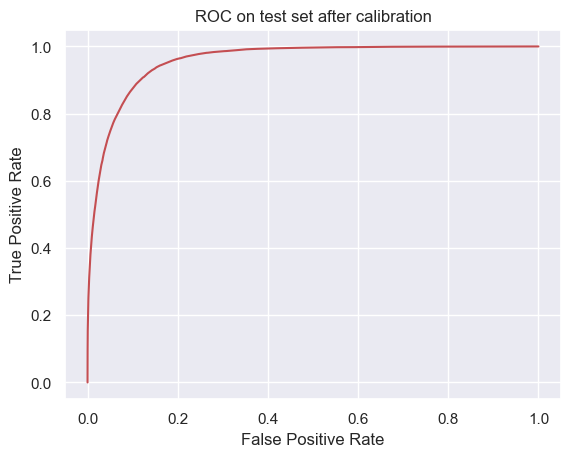

In [175]:
pred_class_test_calibrated = cal_LGB_isotonic.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_class_test_calibrated)
plt.plot(fpr,tpr, 'r')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC on test set after calibration')
plt.show()

## (11) Feature importances

In [231]:
feature_importances = pd.DataFrame({'Columns' : X_dev_selected.columns.tolist(), 
                                    'Feature_importance' : model.feature_importances_.tolist()})

In [238]:
feature_importances_20 = feature_importances.sort_values('Feature_importance', ascending=True).reset_index().iloc[-20:]
feature_importances_20

,index,Columns,Feature_importance
280,63,B_7_last,9
281,86,D_59_max,9
282,299,D_64_mode,10
283,188,R_3_last,10
284,179,D_52_min,10
285,246,D_55_diff1,10
286,44,B_1_last,10
287,57,B_9_last,11
288,92,P_2_mean,11
289,190,S_3_last,12


<BarContainer object of 20 artists>

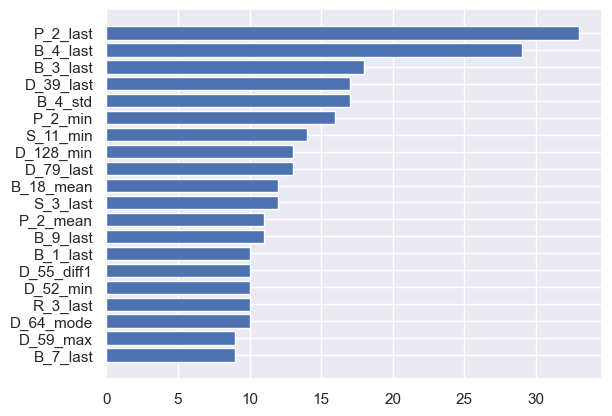

In [239]:
plt.barh(y = feature_importances_20.Columns, width = feature_importances_20.Feature_importance)